Dimensionality Reduction Comparison
---
#### Method Testing
##### May 2019


Using discrete (`inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz`, Mocosko, _et al_ 2015) and continuous (`inputs/qi_s1_edited_all.csv.gz`) datasets, downsample and feature select, then perform various DR techniques and compare the following:
* __Euclidean cell-cell distance__ correlations before and after transformation/reduction
* __Kullback-Leibler Divergence (KLD)__ explaining the Shannon entropy of the difference between the cumulative probability distributions of unique, normalized cell-cell distances.
* __K-nearest neighbor (Knn)__ preservation

In [1]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

Using TensorFlow backend.
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [2]:
P14Retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

In [3]:
P14Retina.data.shape

(6600, 20478)

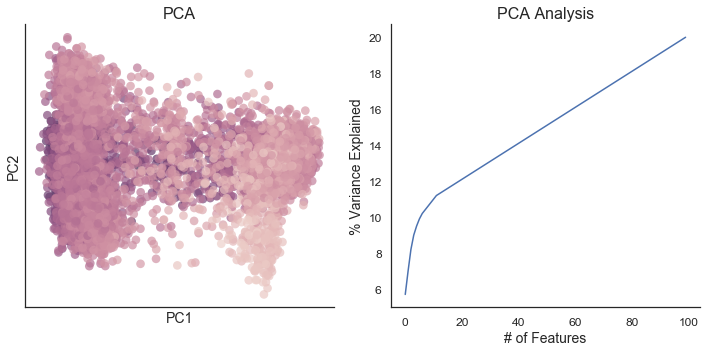

In [4]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(norm='l1'), n_components=100)
P14Retina_PCA100.plot_PCA()

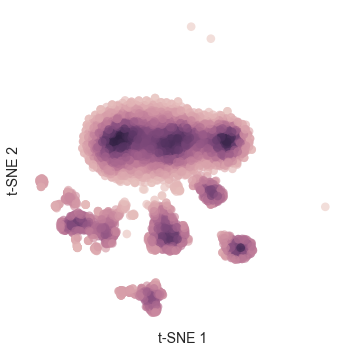

CPU times: user 1min 6s, sys: 1.98 s, total: 1min 8s
Wall time: 1min 10s


In [5]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30, seed=18) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12a98c550>)

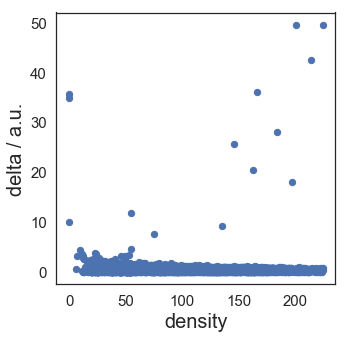

In [6]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12aceef98>)

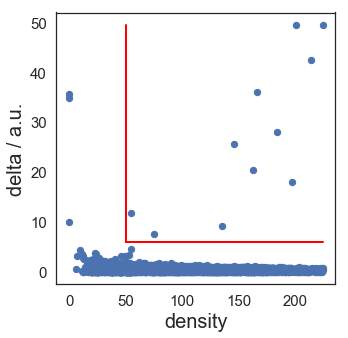

In [7]:
P14Retina_tSNE.clu.assign(50,6) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

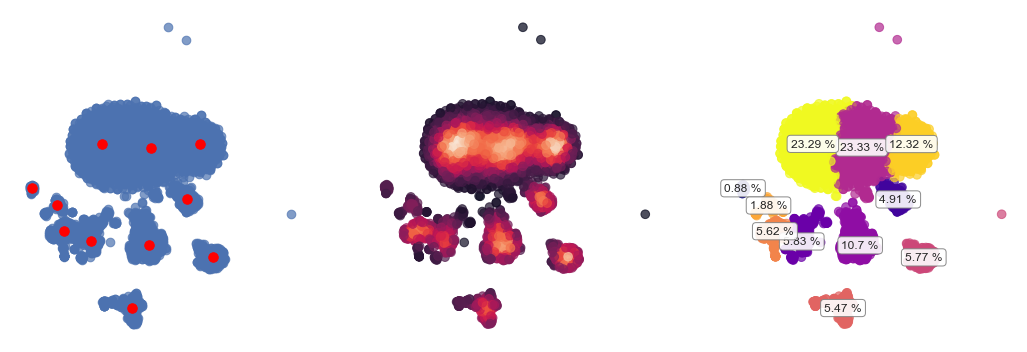

In [8]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [9]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.5033601522445679



---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_
* _ZIFA_

In [10]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [11]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

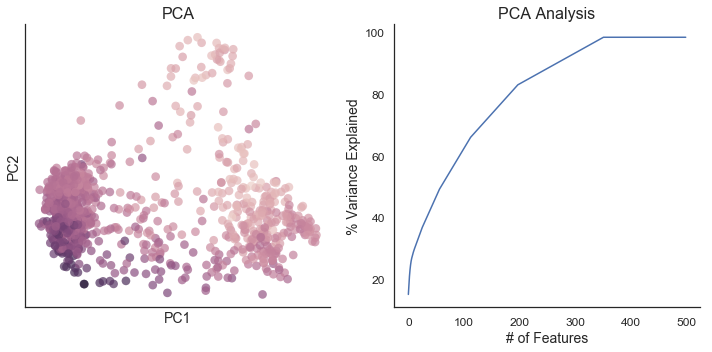

In [12]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot_PCA()

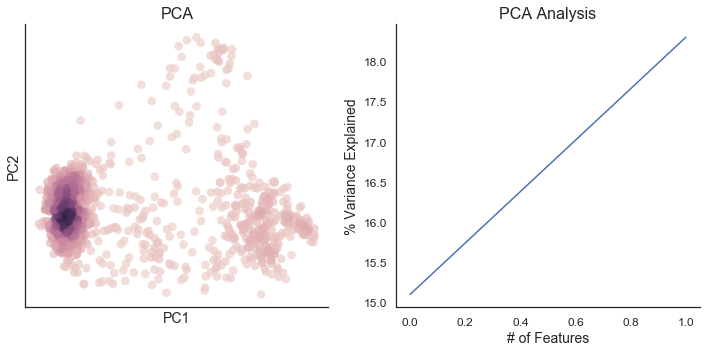

In [13]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot_PCA()

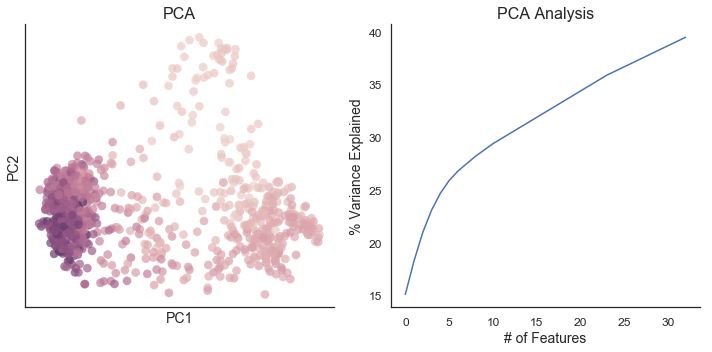

In [14]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot_PCA()

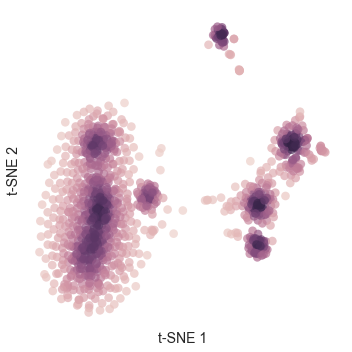

In [15]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

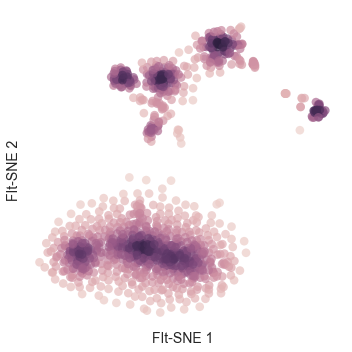

In [16]:
P14Retina_0_FItSNE = fcc_FItSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # t-SNE with perplexity 30
P14Retina_0_FItSNE.plot()

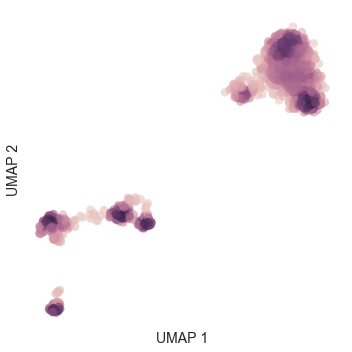

In [17]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [18]:
%time P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts of 500 selected features

DCA: Successfully preprocessed 500 genes and 1005 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 19.7 s, sys: 2.51 s, total: 22.2 s
Wall time: 15.2 s


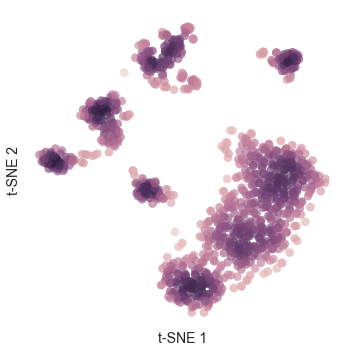

In [19]:
dca = RNA_counts(data=P14Retina_0_DCA.results)
P14Retina_0_DCAtSNE = fcc_tSNE(dca.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # t-SNE with perplexity 30 to visualize DCA
P14Retina_0_DCAtSNE.plot()

In [20]:
%%time
P14Retina_0_ZIFA = fcc_ZIFA(P14Retina_0.arcsinh_norm(norm='l1'), K=2)

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1005, D = 482, K = 2, n_blocks = 1
Block sizes [482]
Param change below threshold 1.000e-02 after 12 iterations
CPU times: user 2min 53s, sys: 27.5 s, total: 3min 21s
Wall time: 1min 46s


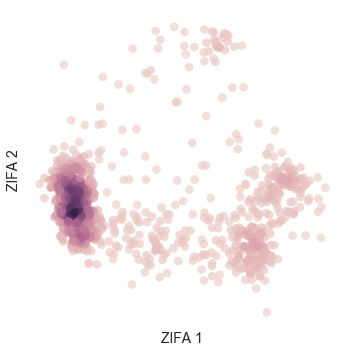

In [21]:
P14Retina_0_ZIFA.plot()

---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [32]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [33]:
k = 30 # choose value for K-nearest neighbor calculations

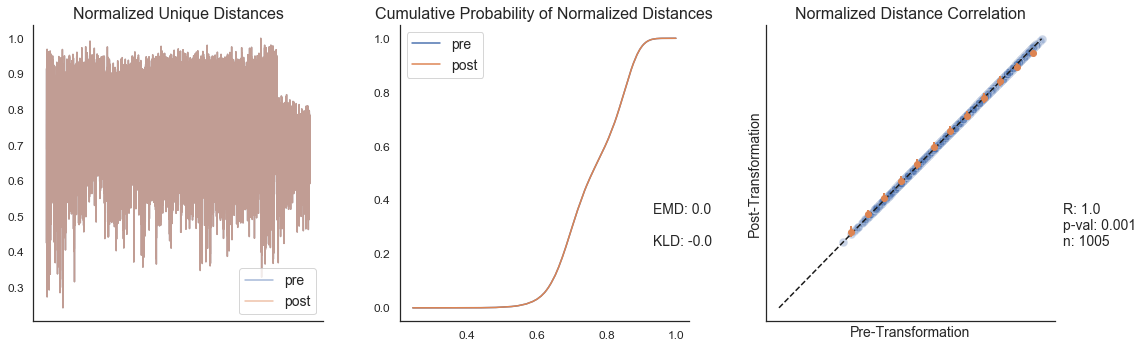

Knn Preservation: 100.0

CPU times: user 33.7 s, sys: 4.58 s, total: 38.3 s
Wall time: 38.9 s


In [34]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

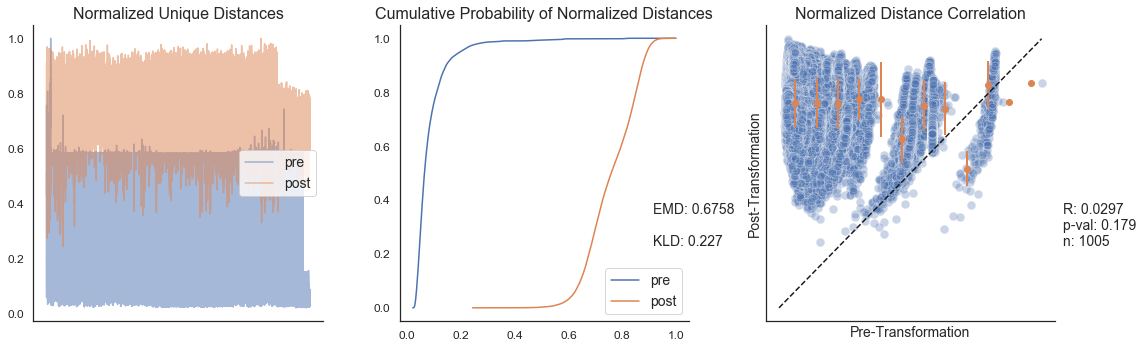

Knn Preservation: 95.6536

CPU times: user 33.1 s, sys: 4.41 s, total: 37.6 s
Wall time: 37.4 s


In [35]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000))))

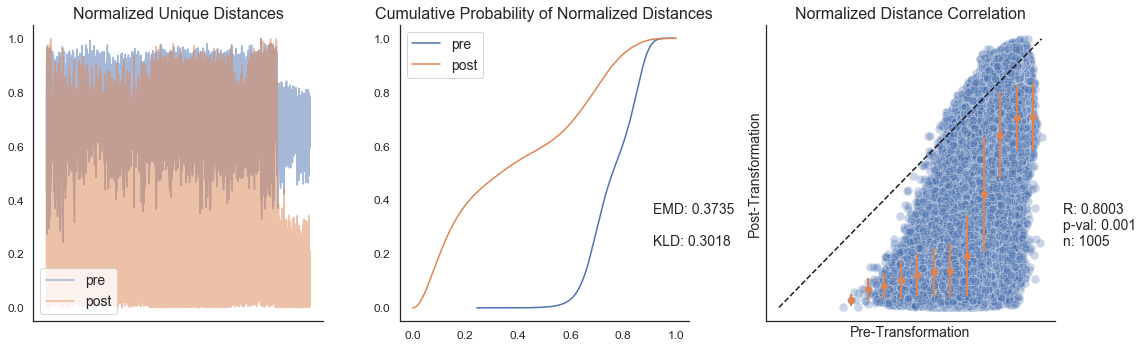

Knn Preservation: 96.0072

CPU times: user 29.6 s, sys: 4.03 s, total: 33.7 s
Wall time: 33.6 s


In [36]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

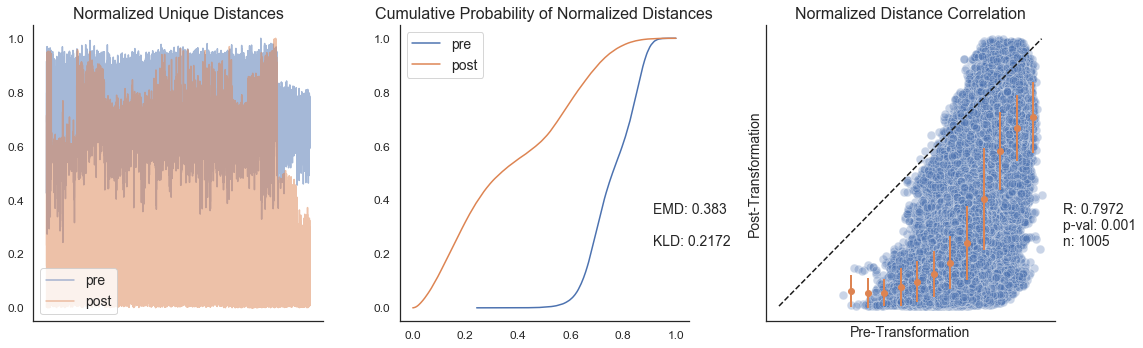

Knn Preservation: 95.5694

CPU times: user 29.8 s, sys: 4.5 s, total: 34.2 s
Wall time: 34.5 s


In [37]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

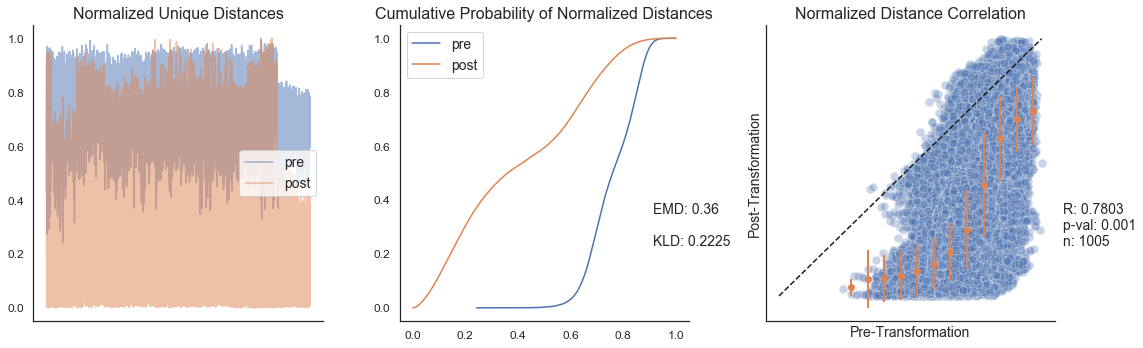

Knn Preservation: 95.6227

CPU times: user 30.1 s, sys: 4.2 s, total: 34.3 s
Wall time: 35.2 s


In [38]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_FItSNE.knn_graph(k))))

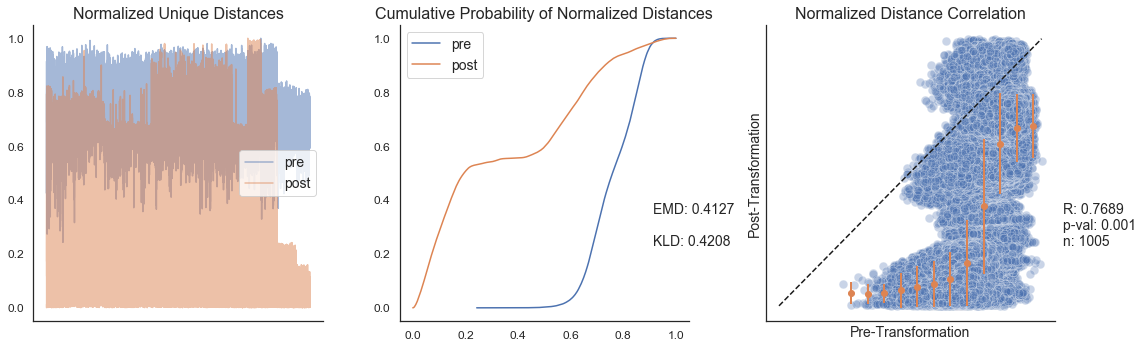

Knn Preservation: 95.3512

CPU times: user 29.6 s, sys: 4.13 s, total: 33.7 s
Wall time: 33.4 s


In [39]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

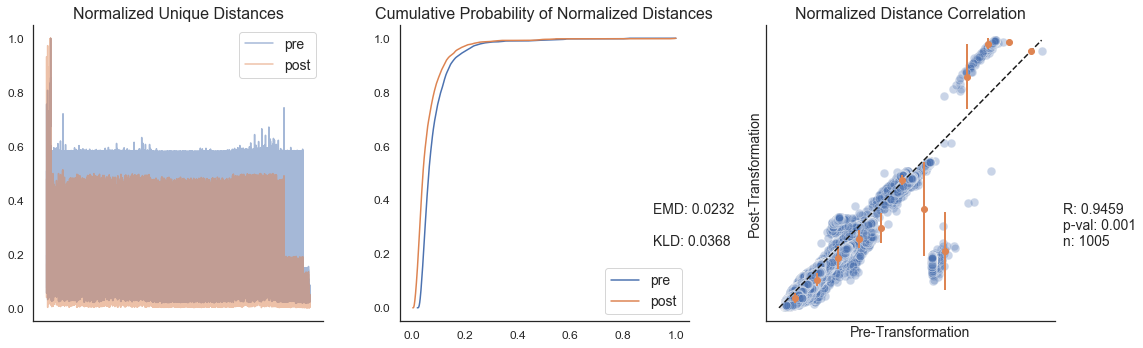

Knn Preservation: 96.5312

CPU times: user 29.2 s, sys: 3.84 s, total: 33.1 s
Wall time: 32.8 s


In [40]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

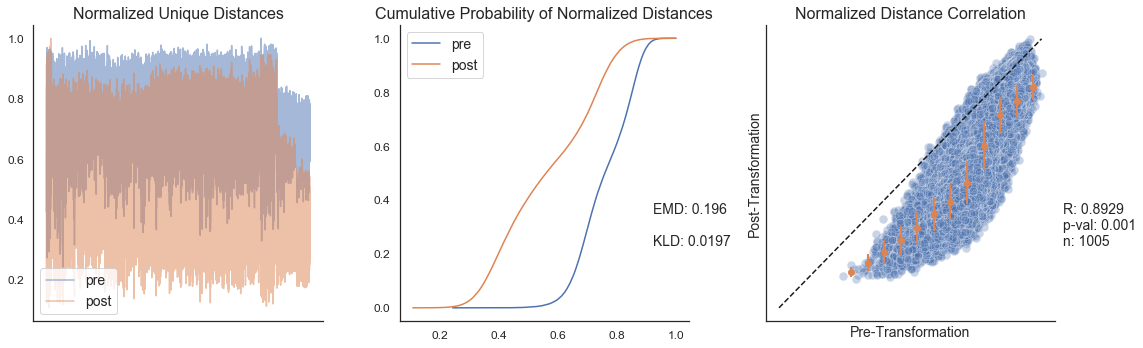

Knn Preservation: 96.8821

CPU times: user 30.3 s, sys: 4.26 s, total: 34.6 s
Wall time: 34.2 s


In [41]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))

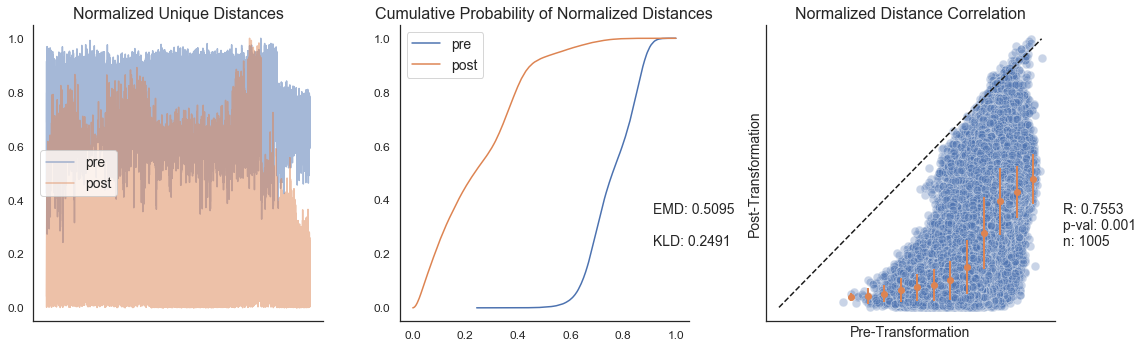

Knn Preservation: 95.4441

CPU times: user 29.6 s, sys: 4.21 s, total: 33.8 s
Wall time: 33.5 s


In [42]:
%%time
# look at ZIFA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_ZIFA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_ZIFA.knn_graph(k))))

---
#### 3. repeat for continuous dataset

---
#### 3.0. read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [43]:
%time qi = RNA_counts.from_file('../inputs/qi_s1_edited_all.csv.gz', cells_axis=0, labels=[None,None])

CPU times: user 15.1 s, sys: 944 ms, total: 16.1 s
Wall time: 16.3 s


In [44]:
qi.data.shape

(1595, 25507)

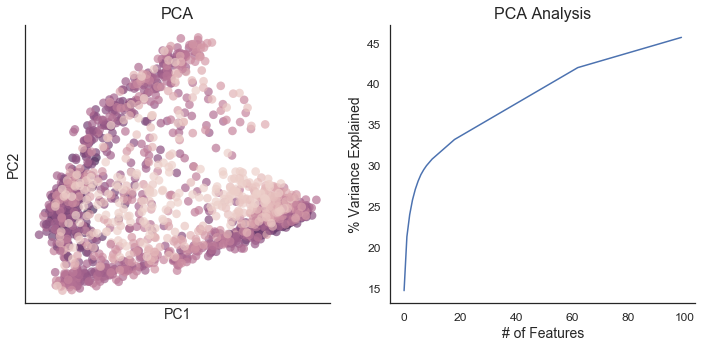

In [46]:
qi_PCA100 = fcc_PCA(qi.arcsinh_norm(), n_components=100)
qi_PCA100.plot_PCA()

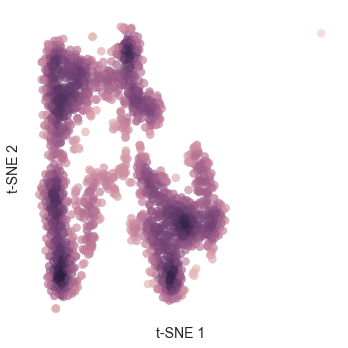

CPU times: user 12.1 s, sys: 111 ms, total: 12.2 s
Wall time: 12.1 s


In [51]:
%%time 
qi_tSNE = fcc_tSNE(qi_PCA100.results, perplexity=30, seed=18) # use standard perplexity of 30 here
qi_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1281c4940>)

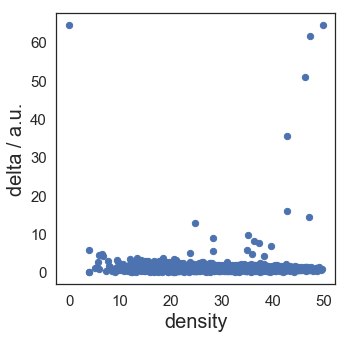

In [52]:
qi_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x125ffad30>)

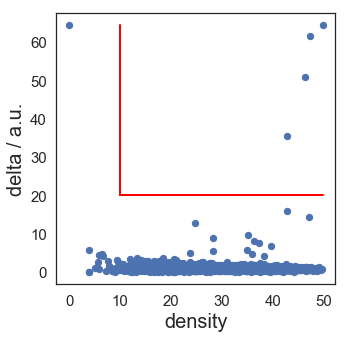

In [53]:
qi_tSNE.clu.assign(10,20) # assign cluster center cutoffs
qi_tSNE.clu.draw_decision_graph(min_delta=qi_tSNE.clu.min_delta, min_density=qi_tSNE.clu.min_density) # plot chosen density-peak cluster centers

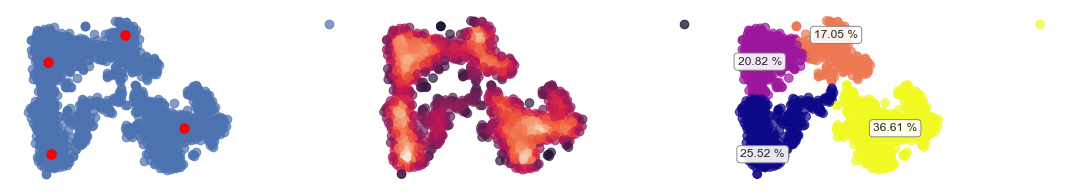

In [54]:
qi_tSNE.plot_clusters() # visualize clustering

In [55]:
print('Silhouette Score: {}\n'.format(qi_tSNE.silhouette_score()))
qi_tSNE.cluster_counts()

Silhouette Score: 0.5219972133636475

407 cells in cluster 0 (25.517 %)

332 cells in cluster 1 (20.815 %)

272 cells in cluster 2 (17.053 %)

584 cells in cluster 3 (36.614 %)



---
#### 3.1. feature-select continuous dataset and perform DRs
* select _500 most variable genes_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_
* _ZIFA_

In [56]:
# select 500 most variable genes
qi_0 = RNA_counts.var_select(qi, n_features=500) 

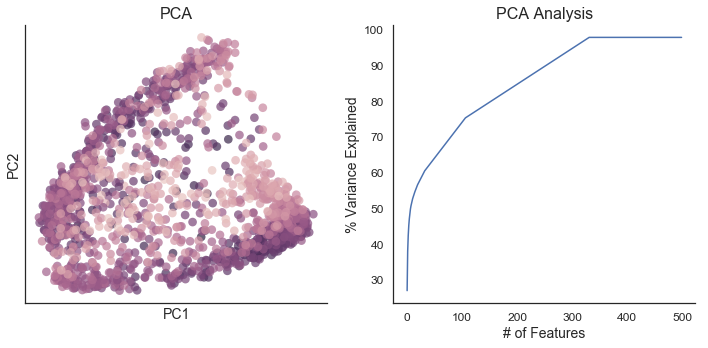

In [58]:
qi_0_PCA500 = fcc_PCA(qi_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
qi_0_PCA500.plot_PCA()

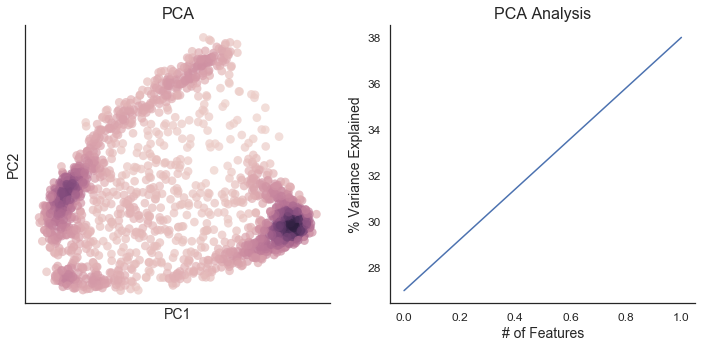

In [59]:
qi_0_PCA2 = fcc_PCA(qi_0.arcsinh_norm(), n_components=2) # 2 component PCA
qi_0_PCA2.plot_PCA()

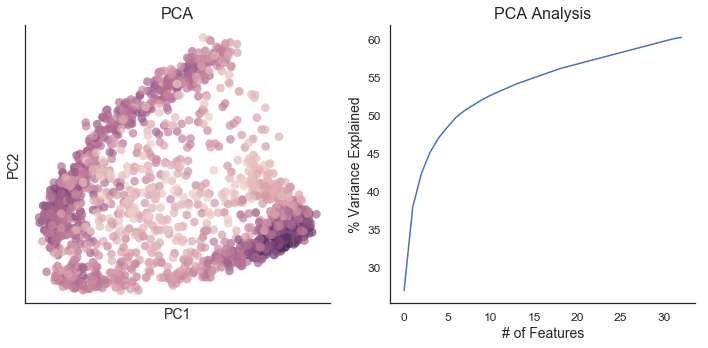

In [60]:
qi_0_PCA33 = fcc_PCA(qi_0.arcsinh_norm(), n_components=33) # 33 component PCA to compare to DCA
qi_0_PCA33.plot_PCA()

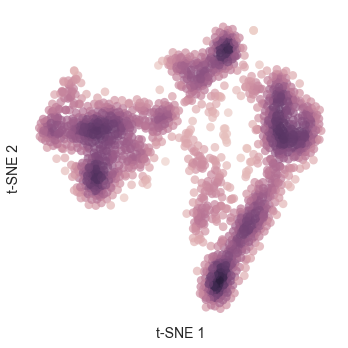

In [61]:
qi_0_tSNE = fcc_tSNE(qi_0.arcsinh_norm(), perplexity=30, seed=18) # t-SNE with perplexity 30
qi_0_tSNE.plot()

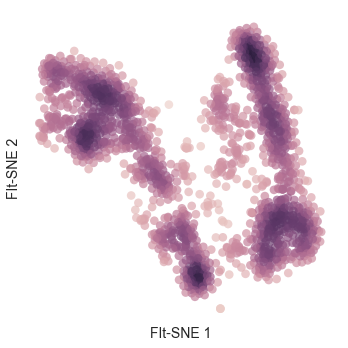

In [62]:
qi_0_FItSNE = fcc_FItSNE(qi_0.arcsinh_norm(), perplexity=30, seed=18) # FIt-SNE with perplexity 30
qi_0_FItSNE.plot()

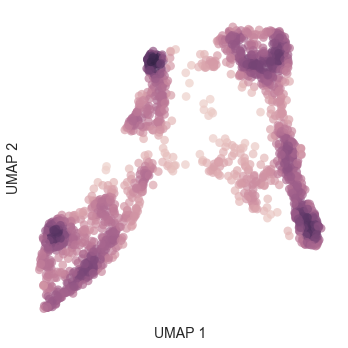

In [63]:
qi_0_UMAP = fcc_UMAP(qi_0.arcsinh_norm(), perplexity=30, seed=18) # UMAP with perplexity 30
qi_0_UMAP.plot()

In [64]:
qi_0_DCA = fcc_DCA(qi_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1595 cells.
Calculating low dimensional representations...
Calculating reconstructions...


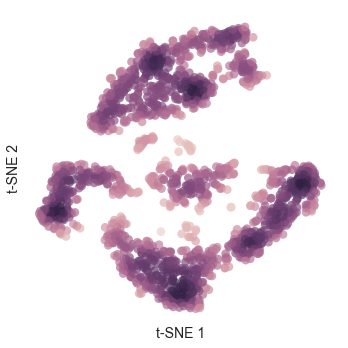

In [65]:
test = RNA_counts(data=qi_0_DCA.results)
qi_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(), perplexity=30, seed=18) # t-SNE with perplexity 30 to visualize DCA
qi_0_DCAtSNE.plot()

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1595, D = 497, K = 2, n_blocks = 1
Block sizes [497]
Param change below threshold 1.000e-02 after 7 iterations


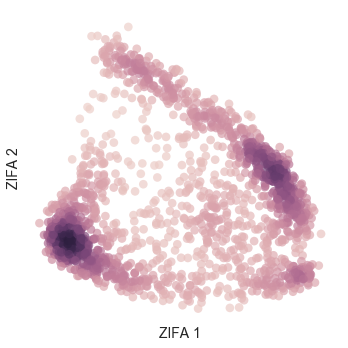

CPU times: user 2min 11s, sys: 20.6 s, total: 2min 31s
Wall time: 1min 18s


In [74]:
%%time
qi_0_ZIFA = fcc_ZIFA(qi_0.arcsinh_norm(), K=2)
qi_0_ZIFA.plot()

---
#### 3.2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

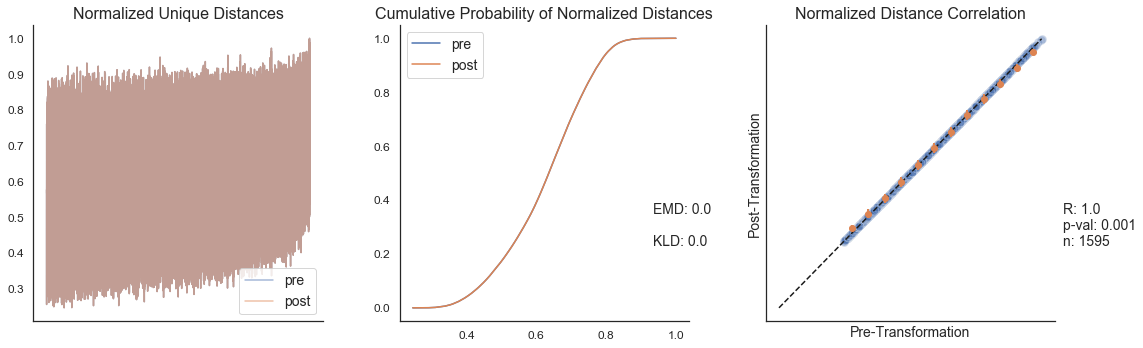

Knn Preservation: 100.0

CPU times: user 1min 32s, sys: 13.8 s, total: 1min 46s
Wall time: 1min 46s


In [66]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA500.knn_graph(k))))

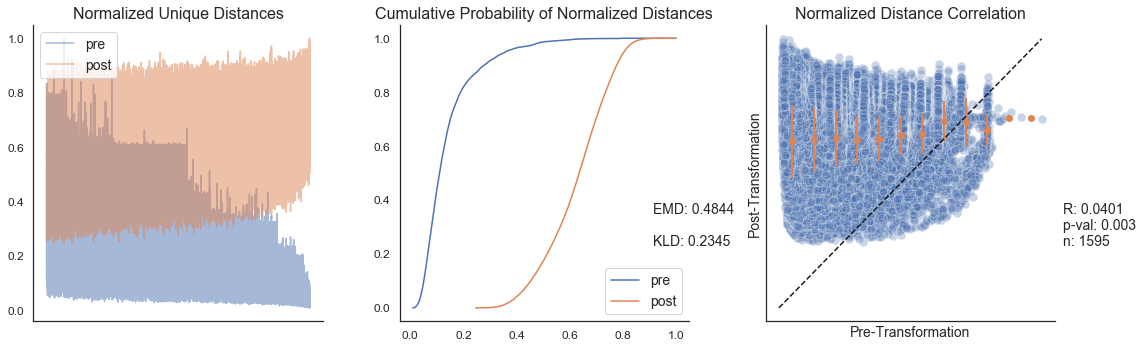

Knn Preservation: 97.1933

CPU times: user 1min 39s, sys: 16.7 s, total: 1min 55s
Wall time: 1min 56s


In [67]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0.knn_graph(k, transform='arcsinh', scale=1000))))

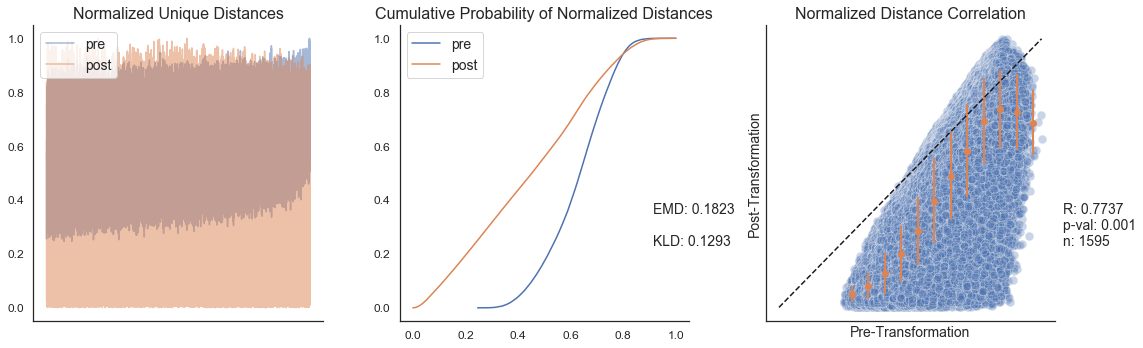

Knn Preservation: 97.7739

CPU times: user 1min 25s, sys: 12.4 s, total: 1min 37s
Wall time: 1min 37s


In [68]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA2.knn_graph(k))))

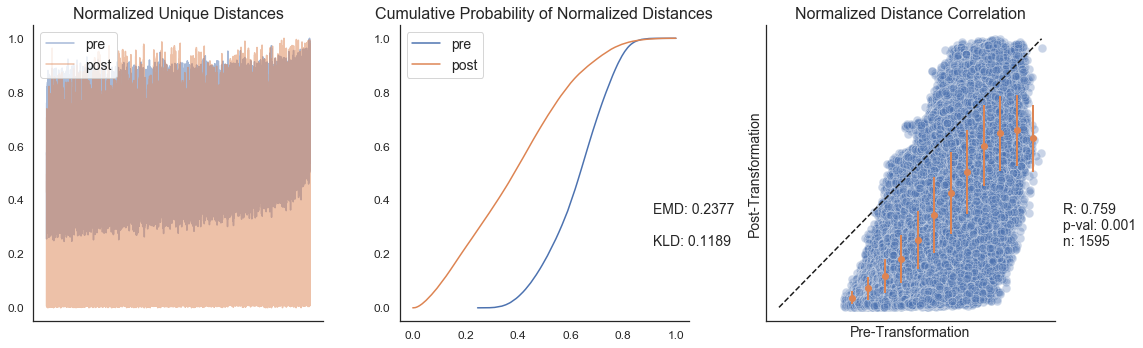

Knn Preservation: 97.6025

CPU times: user 1min 24s, sys: 12 s, total: 1min 36s
Wall time: 1min 36s


In [69]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_tSNE.knn_graph(k))))

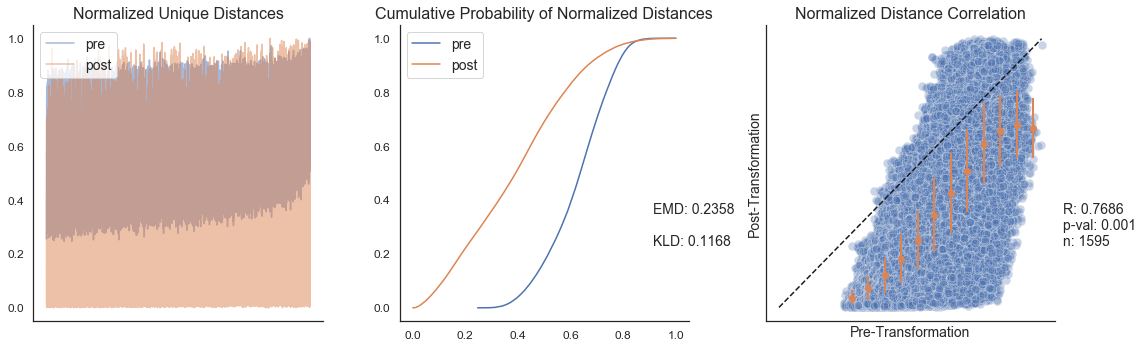

Knn Preservation: 97.6233

CPU times: user 1min 23s, sys: 11.5 s, total: 1min 35s
Wall time: 1min 35s


In [70]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_FItSNE.knn_graph(k))))

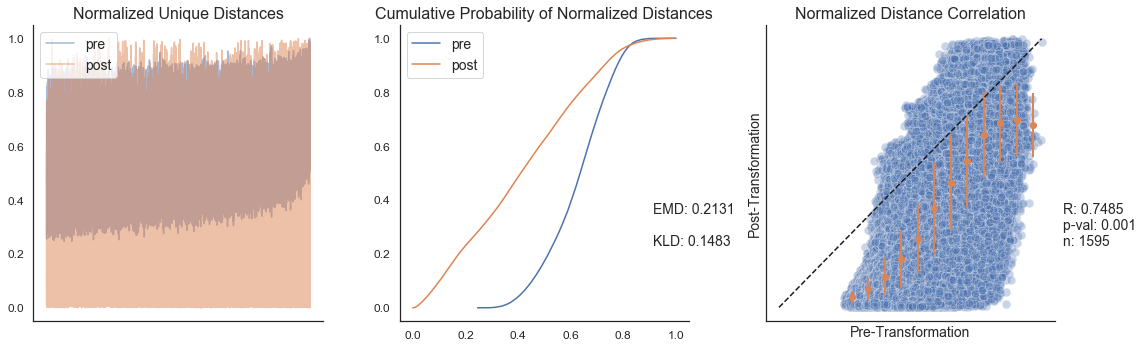

Knn Preservation: 97.5229

CPU times: user 1min 22s, sys: 11.6 s, total: 1min 34s
Wall time: 1min 34s


In [71]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_UMAP.knn_graph(k))))

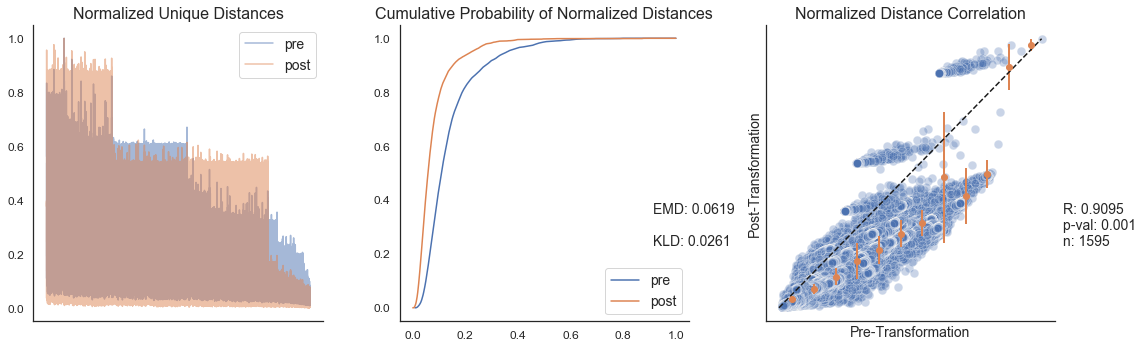

Knn Preservation: 98.153

CPU times: user 1min 25s, sys: 13.6 s, total: 1min 38s
Wall time: 1min 38s


In [72]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0_DCA.knn_graph(k))))

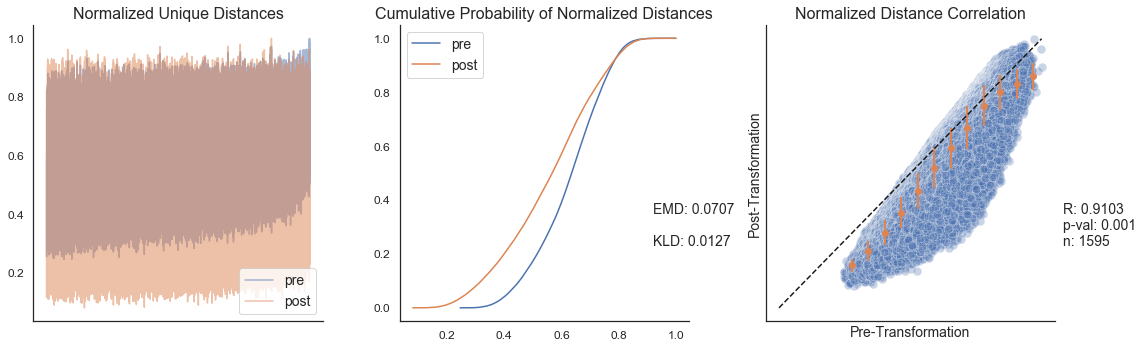

Knn Preservation: 98.3891

CPU times: user 1min 25s, sys: 11.5 s, total: 1min 36s
Wall time: 1min 36s


In [73]:
%%time
# look at 33-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA33.knn_graph(k))))

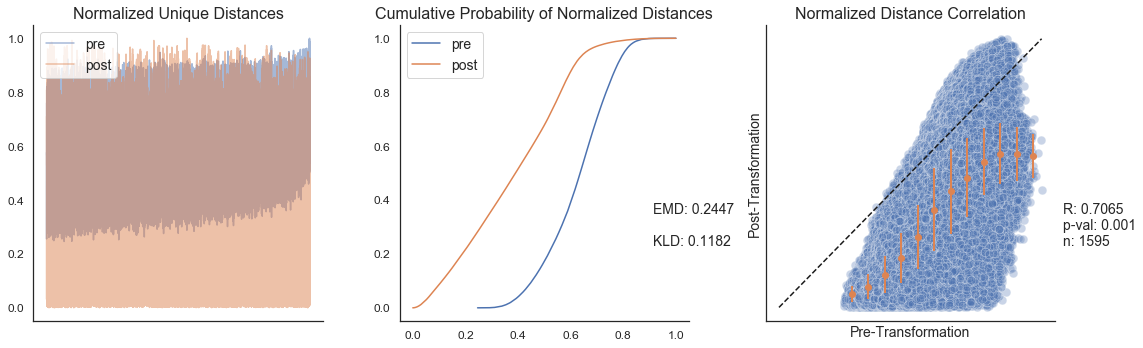

Knn Preservation: 97.557

CPU times: user 1min 22s, sys: 11.1 s, total: 1min 33s
Wall time: 1min 33s


In [75]:
%%time
# look at ZIFA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_ZIFA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_ZIFA.knn_graph(k))))